In [1]:
import numpy as np

In [2]:
import grasshopper.sources as sources
import grasshopper.interferometers as detectors

In [3]:
import matplotlib.pyplot as plt

In [4]:
data = np.genfromtxt("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m8_L0.45_l2m2_r200.dat")

In [5]:
import minke.sources

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
from glob import glob
waveforms = glob("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h*.dat")

In [13]:
mwaveforms = []
for datafile in waveforms:
    test_wave = minke.sources.Hyperbolic(datafile, total_mass=100, distance=10)
    #f = test_wave.plot();
    #f.suptitle("{}".format(datafile))
    mwaveforms.append(test_wave)
    np.savetxt("rescale-{}".format(datafile.split("/")[-1]), test_wave._make_strain(4096))

In [14]:
!head rescale-h_m16_L0.18_l2m2_r300.dat

0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00
2.441406250000000000e-04 6.298617017036727996e-27 3.366414141929026615e-27
4.882812500000000000e-04 1.259192732271718125e-26 6.704760423017017916e-27
7.324218750000000000e-04 1.887993392955148754e-26 1.001505657184352693e-26
9.765625000000000000e-04 2.516263996917858229e-26 1.329732033955668848e-26
1.220703125000000000e-03 3.144004843917959690e-26 1.655156952808395503e-26
1.464843750000000000e-03 3.771216241854907426e-26 1.977782190579350298e-26
1.708984375000000000e-03 4.397874881044107225e-26 2.297484612109945183e-26
1.953125000000000000e-03 5.024002370521673402e-26 2.614378684642010848e-26
2.197265625000000000e-03 5.649601369997439902e-26 2.928478590820220316e-26


In [8]:
import grasshopper.sources
from scipy.signal import windows
import scipy.interpolate as interp

In [26]:
class MinkeSignal(grasshopper.sources.Source):
    """
    A signal which is generated by the Minke package.
    """
    name = "Minke Signal"
    frequencies = np.linspace(0.1, 1000, 1000) * grasshopper.sources.u.hertz
    
    def __init__(self, source, name=None, frequencies=None, **params):
        if frequencies: self.frequencies = frequencies
        if name: self.name = name
        self.waveform = source(**params)
        self.strain_of_t = self.waveform._make_strain(sample_rate=5*4096)
        
    def raw_strain(self, frequencies=None, fft_len=5*4096):
        
        if not frequencies: frequencies = self.frequencies
            
        delta_t = np.diff(self.strain_of_t[:,0])[0]
        strain_of_f = 1./np.sqrt(fft_len)*np.fft.fft(windows.hanning(len(self.strain_of_t[:,1]))*self.strain_of_t[:,1], fft_len)
        freqs = np.fft.fftfreq(fft_len, delta_t)
        
        interpolator = interp.interp1d(freqs, np.sqrt((strain_of_f* strain_of_f.conj()).real), "linear")
        return interpolator(frequencies.value)

In [27]:
waveform = MinkeSignal(minke.sources.Hyperbolic, 
                       datafile="/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.21_l2m2_r200.dat", 
                       total_mass=10, 
                       name = "h_m16_L0.21_l2m2_r200",
                       distance=0.1)
waveform2 = MinkeSignal(minke.sources.Hyperbolic, 
                       datafile="/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.21_l2m2_r200.dat", 
                       total_mass=100, 
                       distance=0.1)
waveform3 = MinkeSignal(minke.sources.Hyperbolic, 
                       datafile="/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.21_l2m2_r200.dat", 
                       total_mass=200, 
                       distance=0.1)

In [28]:
from grasshopper import interferometers

In [29]:
aligo = interferometers.AdvancedLIGO(frequencies=np.linspace(10, 1000, 1000)*grasshopper.interferometers.u.hertz)
iligo = interferometers.InitialLIGO(frequencies=np.linspace(10, 1000, 1000)*grasshopper.interferometers.u.hertz)
decigo = interferometers.Decigo(frequencies=np.linspace(0.01, 50, 1000)*grasshopper.interferometers.u.hertz)
et = interferometers.EinsteinTelescope()

0.893660640769
0.438206471349
5.96894529033


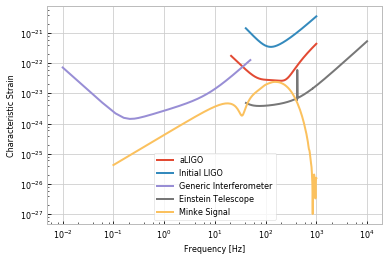

In [32]:
waveform = MinkeSignal(minke.sources.Hyperbolic, 
                       datafile="/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m4_L0.8_l2m2_r400.dat", 
                       total_mass=10, 
                       distance=500)
f, ax = plt.subplots(1,1)
aligo.plot(ax)
iligo.plot(ax)
decigo.plot(ax)
et.plot(ax)
waveform.plot(ax)

#print(waveform.snr(iligo))
print(waveform.snr(aligo).value)
print(waveform.snr(decigo).value)
print(waveform.snr(et).value)

In [36]:
from matplotlib import rc, font_manager
lato = {'family': 'Lato',
        'color':  'black',
        'weight': 'light',
        'size': 10,
        }
source_code_pro = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 6,
        }
ticks_font = font_manager.FontProperties(**source_code_pro)
import matplotlib.patheffects as path_effects

In [52]:
def make_snr_contours(datafile, max_distance=200, detector=aligo, snrs=[8]):
    #for datafile in waveforms:
    
    snr = []
    masses = np.linspace(5,100,50)
    distances = np.linspace(0.1, max_distance, 50)
    #datafile = "/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.24_l2m2_r200.dat"
    for mass in masses:
        for distance in  distances:
            waveform = MinkeSignal(minke.sources.Hyperbolic, 
                                   datafile=datafile,
                                   total_mass=mass, 
                                   distance=distance)

            snr.append(waveform.snr(detector).value)

    # ---

    f, ax = plt.subplots(1,1,dpi=300, figsize=(6,6/1.616))

    #ax.set_title("{}".format(datafile.split("/")[-1]), fontdict=lato)

    snr = np.array(snr).reshape(len(distances),len(masses))
    contours = ax.contour(distances, masses, snr, levels=np.arange(0,40,2)[np.arange(0,40,2) != 8], 
                          origin="lower", colors="#ff8959", linewidths=0.5)
    contours = ax.contour(distances, masses, snr, levels=snrs, origin="lower", colors="#ff8959", linewidths=2)
    c_labels = ax.clabel(contours, fmt="%.0f")


    ax.grid(which="both", color='#348ABD', alpha=0.4, lw=0.3,)

    for label in c_labels:
        label.set_font_properties(ticks_font)
        label.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                           path_effects.Normal()])

    ax.set_xlabel("Distance [Mpc]", fontdict=lato)
    ax.set_ylabel(r"Total Mass [$\mathrm{M}_\odot$]", fontdict=lato)

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)

    f.tight_layout()
    return f

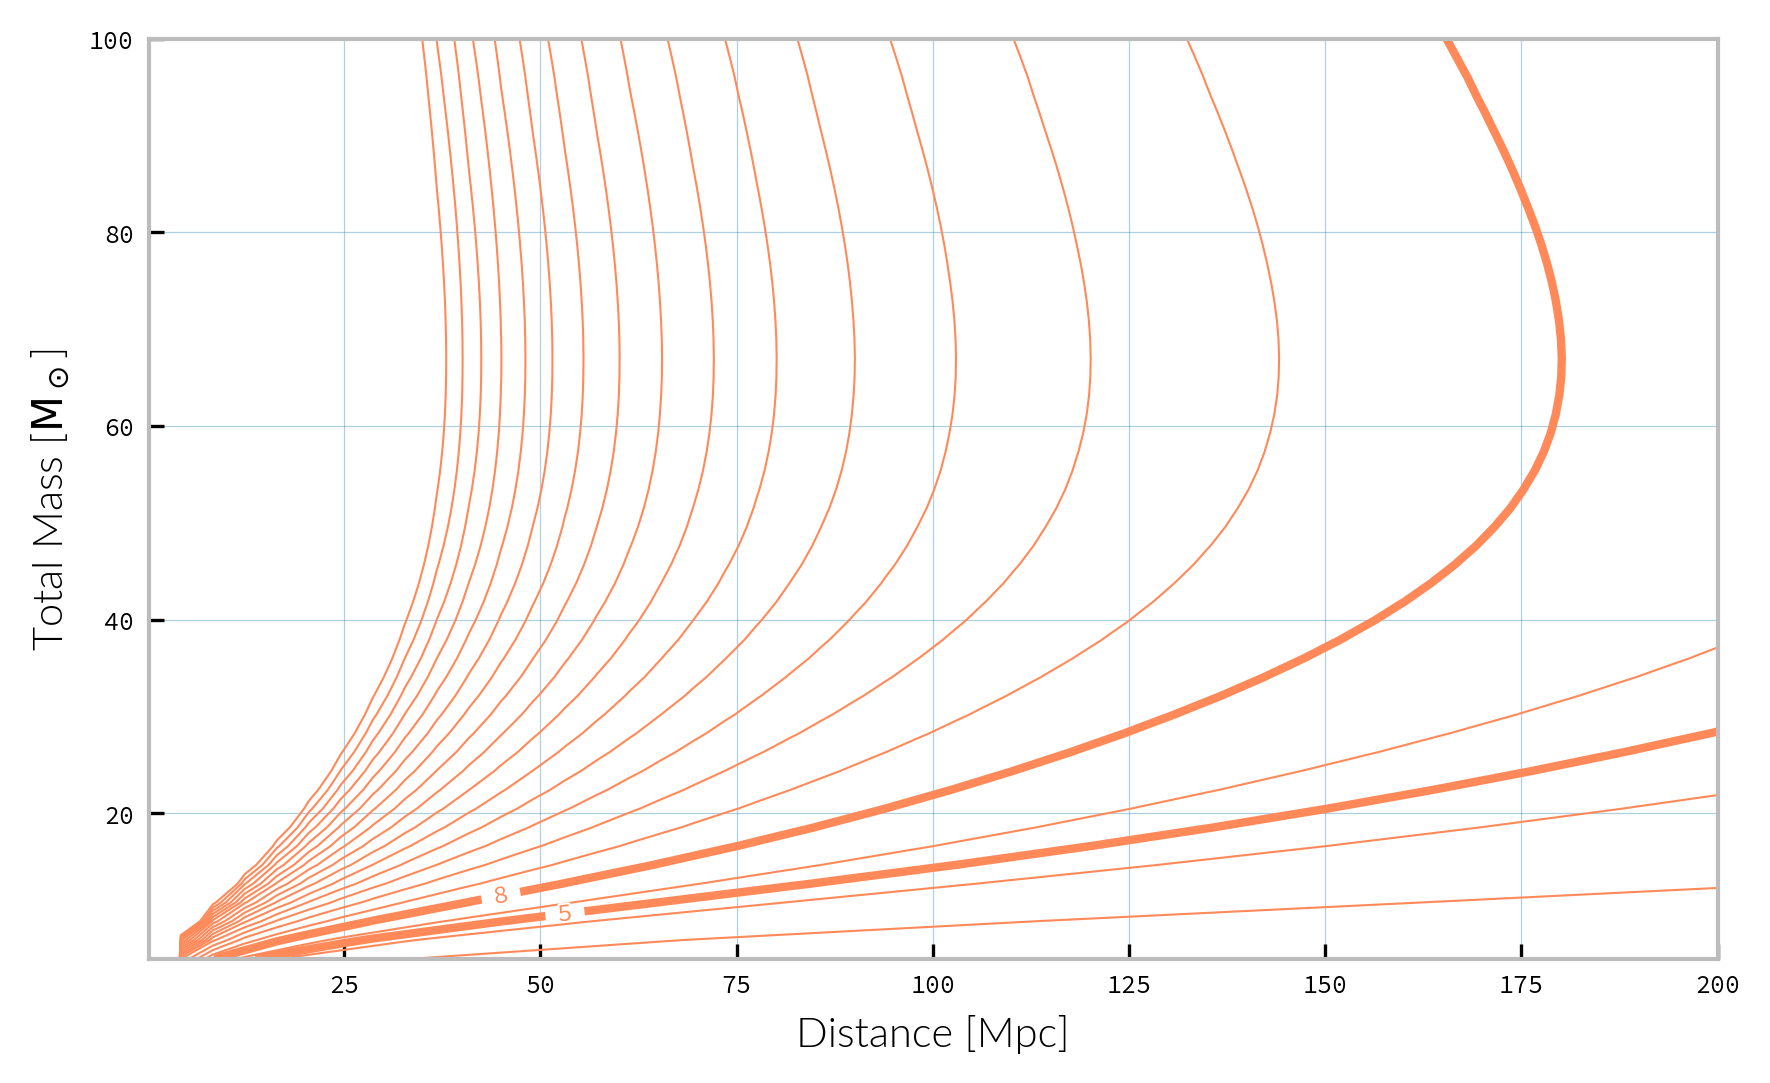

In [53]:
f = make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.24_l2m2_r200.dat",
                 snrs=[5,8]
                 )
f.savefig("hyperbolic-m16-l0.24.pdf")

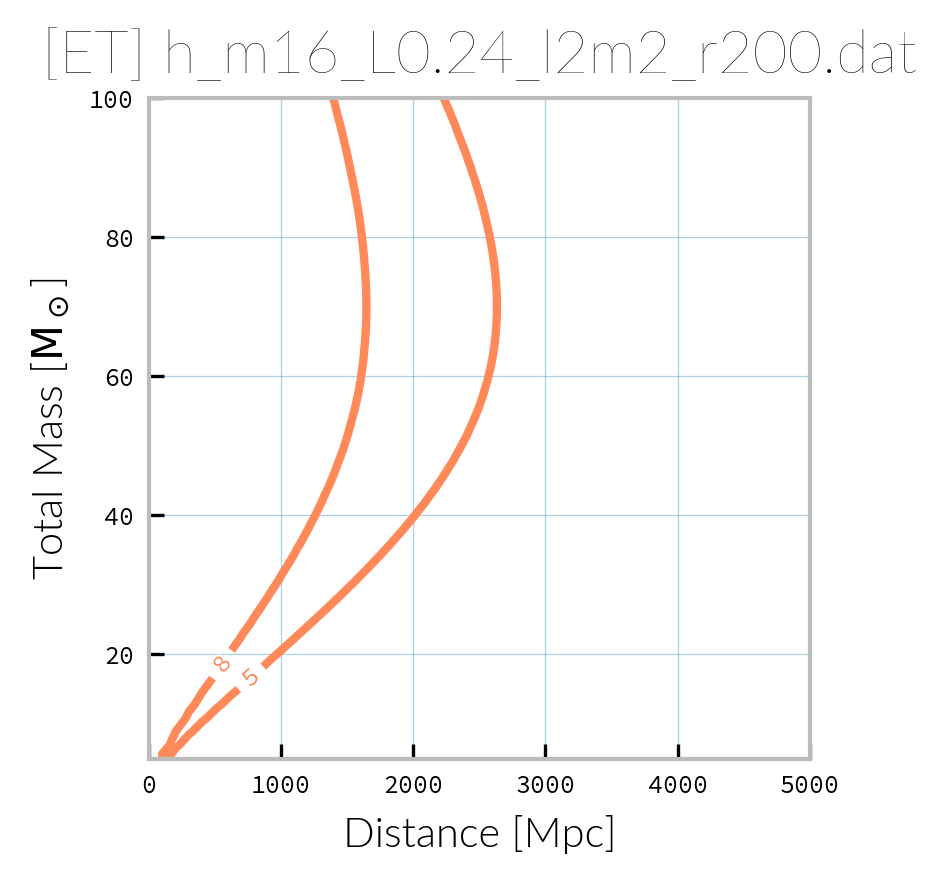

In [45]:
f = make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.24_l2m2_r200.dat", 
                      snrs=[5,8],
                      detector=et, max_distance=5000);
f.axes[0].set_title("[ET] {}".format(f.axes[0].get_title()))

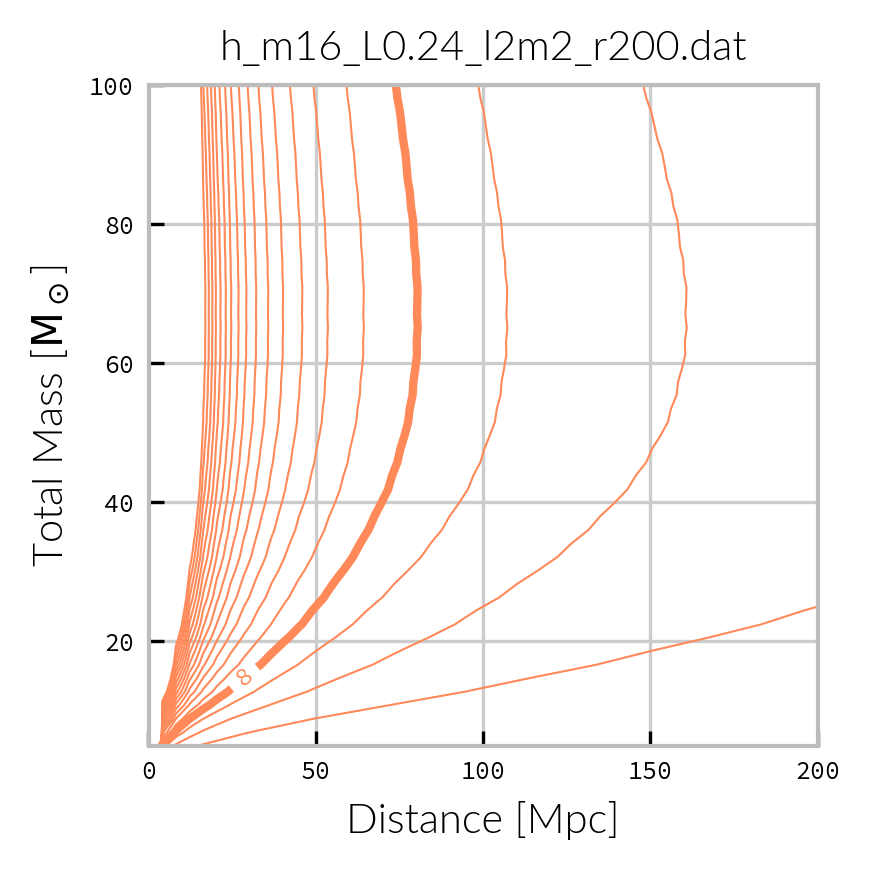

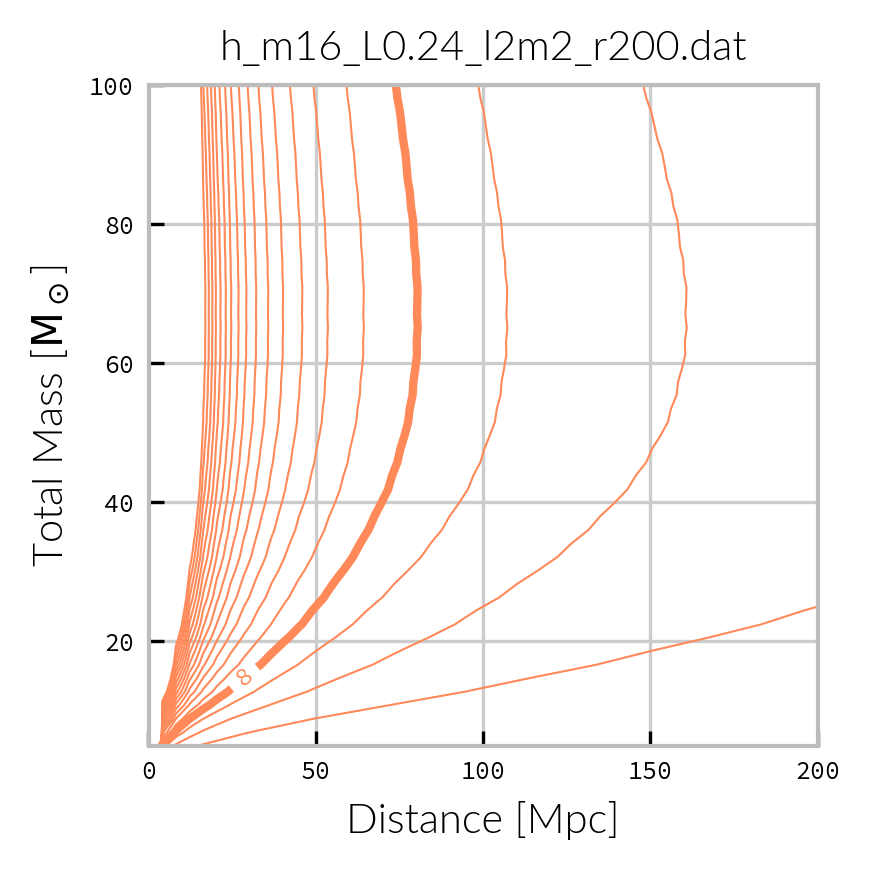

In [19]:
make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.18_l2m2_r300.dat")

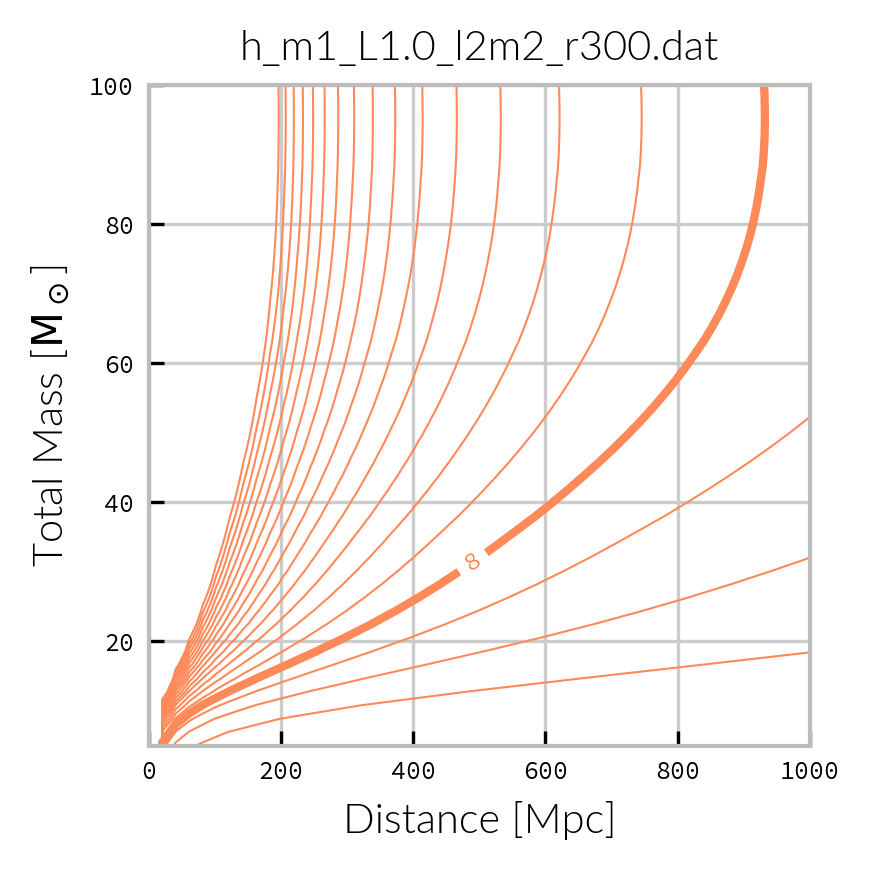

In [61]:
make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m1_L1.0_l2m2_r300.dat");

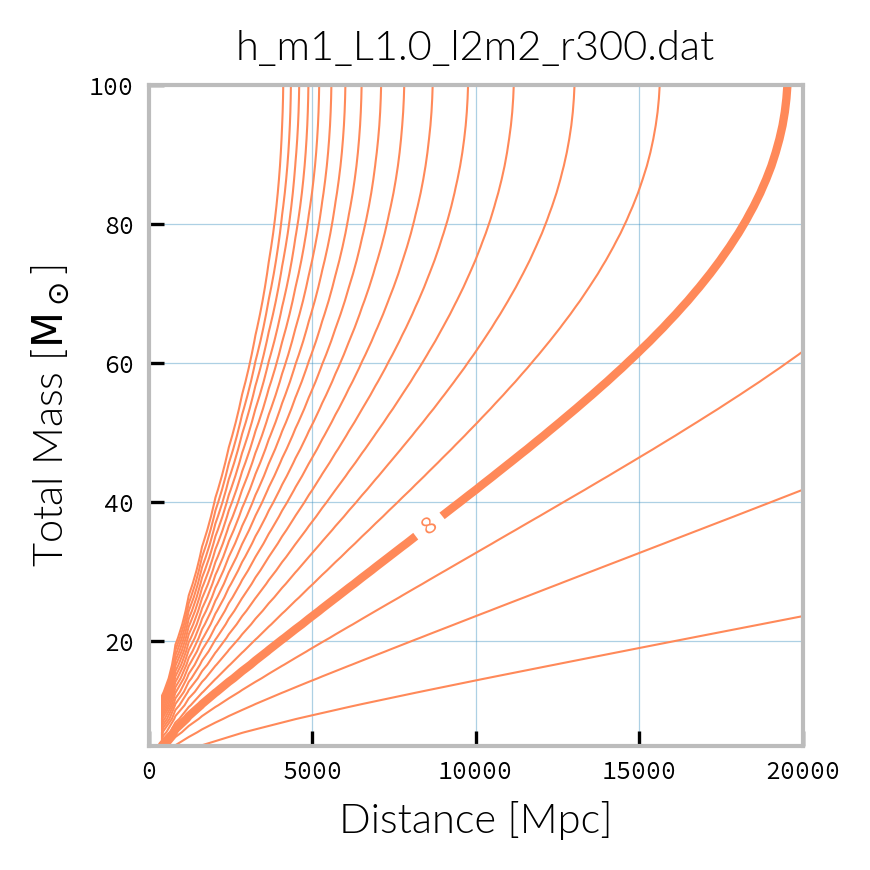

In [41]:
make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m1_L1.0_l2m2_r300.dat", 
                  max_distance=20000, detector=et);

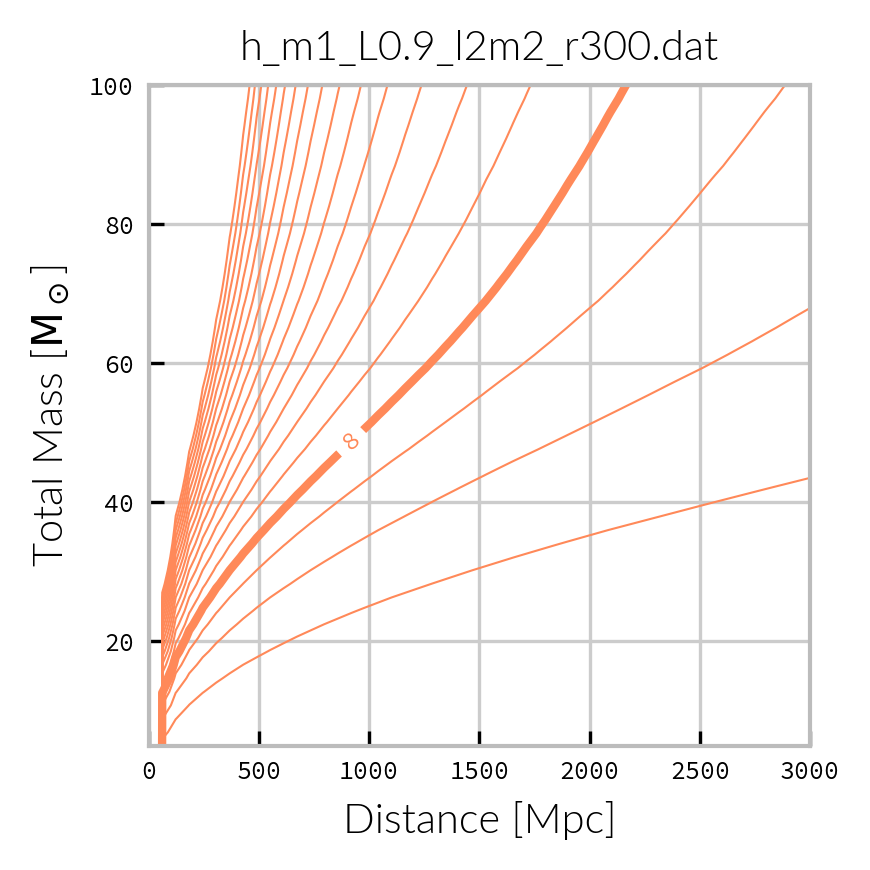

In [71]:
f = make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m1_L0.9_l2m2_r300.dat", max_distance=3000);

In [108]:
f.axes[0].grid(which="both", color='#348ABD', alpha=0.4, lw=0.3,)

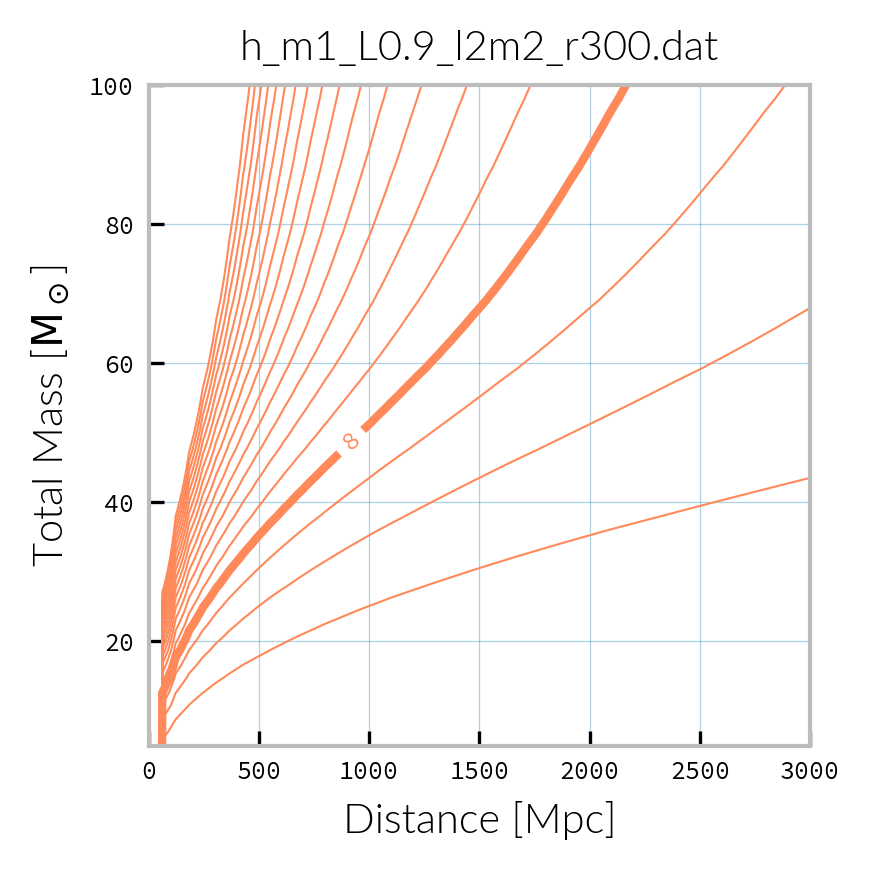

In [109]:
f

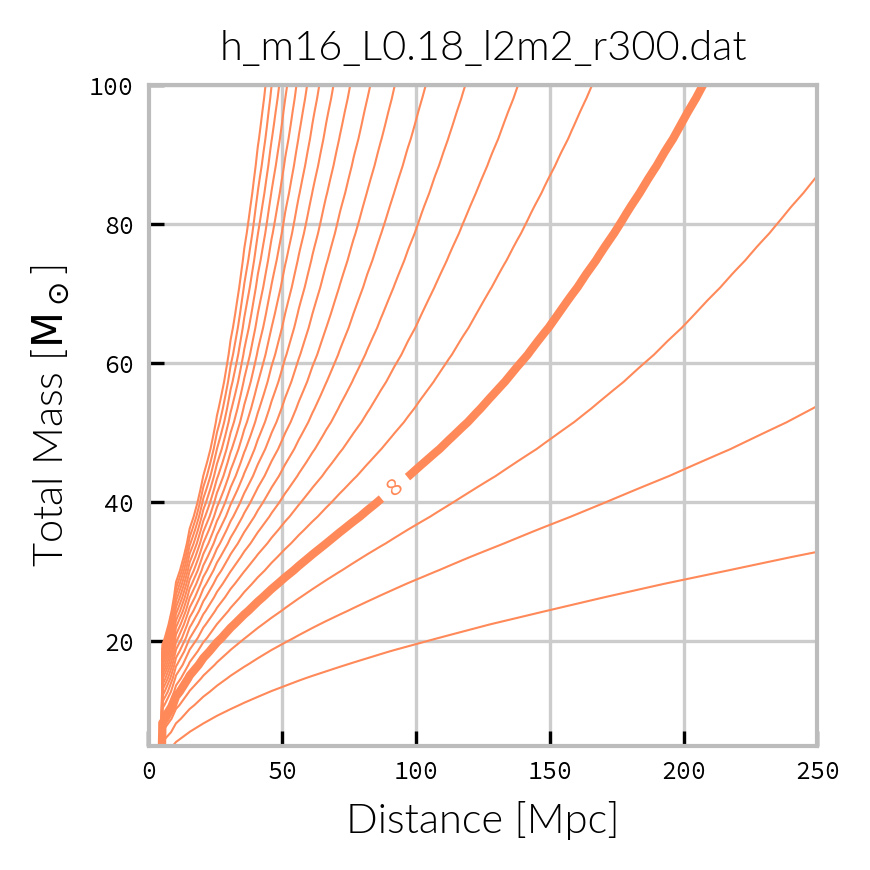

In [70]:
make_snr_contours("/home/daniel/data/gravitational-waves/hyperbolic/h_psi4/h_m16_L0.18_l2m2_r300.dat", max_distance=250);

In [41]:
def components_from_total(total_mass, mass_ratio):
    """
    Calculate the component black hole masses from the total mass
    of the system and the mass ratio.
    """
    m1 = total_mass / (mass_ratio + 1.)
    m2 = total_mass - m1

    return m1, m2

In [47]:
def q2mu(q, T):
    """
    Convert the mass ratio to the reduced mass.    
    """
    m1, m2 = components_from_total(T, q)
    mu = T / m1*m2
    
    return mu

In [54]:
q2mu(1./16, 100)

6.249999999999993

In [55]:
def impact(L, q, T, E):
    mu = q2mu(q, T)
    return L / np.sqrt(2*mu*E)

In [65]:
impact(1.5, q=1./16, T=100, E=1e-9)

13416.407864998746